In [27]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import glob
import sys
from tqdm import tqdm
from scipy import signal
import pandas as pd

In [37]:
def measure_shocks (suite, amplitudes=(1,2,5,10,20,50,75,100)):
    
    for ampl in amplitudes:

        print(f'Amplitude: {ampl}', flush=True)

        plt.figure(figsize=(8,8))
        gs = GridSpec(3,2)

        # first, find the collision time using 1D data

        rhomax = []
        rho_prev = np.inf; i_start = 0
        for i in tqdm(range(len(os.listdir(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr0ampl{ampl}/joined_vtk')))):
            with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr0ampl{ampl}/joined_vtk/IntSh2-p1.{i:04d}.vtk.pkl', 'rb') as f:
                data = pkl.load(f)[0]
            rho = np.max(data['rho'])
            if rho > rho_prev: # ignore the initial decompression
                rhomax.append(rho)
                rho_prev = -np.inf
                if not i_start: i_start = i
            else:
                rho_prev = rho
                continue
            del data

        i_coll = np.argmax(rhomax)+i_start
        print(f' - maximum shock compression at i = {i_coll}', flush=True)

        plt.subplot(gs[0,0])
        plt.plot(range(len(rhomax)), rhomax)
        plt.axvline(i_coll-i_start, color='r')

        with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr0ampl{ampl}/joined_vtk/IntSh2-p1.{i_coll:04d}.vtk.pkl', 'rb') as f:
            data = pkl.load(f)[0]
        rho = np.max(data['rho'])

        plt.subplot(gs[0,1])
        plt.contourf(data['x1v'], data['x2v'], data['rho'], 64)
        plt.xlim(-1,1)

        # then, fine-tune on 2D data ------------------------------------------
        try:

            margin = 1.0 # how far from the center do we expect the shock
            dvel_threshold = 0.1
            rhomax = []
            rho_prev = np.inf; i_start = 0

            # load the snapshot
            with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr1ampl{ampl}/joined_vtk/IntSh2-p1.{i_coll:04d}.vtk.pkl', 'rb') as f:
                data = pkl.load(f)[0]

            # basic properties
            dx = data['x1v'][1] - data['x1v'][0]
            middle = len(data['x1v']) // 2
            idx_margin = int(margin / dx)

            # find the shock front by local extrema of dvx/dx
            vel = data['vel1'][:,(middle-idx_margin):(middle+idx_margin)]
            dvel = signal.convolve2d(vel, [[-1,1]], mode='valid')
            xavg = 0.5*(data['x1v'][(middle-idx_margin+1):(middle+idx_margin)] + data['x1v'][(middle-idx_margin):(middle+idx_margin-1)])

            shock_y, shock_x = map(np.array, np.where(np.abs(dvel) > dvel_threshold))

            plt.subplot(gs[1,0])
            plt.plot(xavg, dvel[10,:])
            plt.xlim(-margin,margin)

            plt.subplot(gs[1,1])
            plt.contourf(xavg, data['x2v'], dvel, 64)
            plt.scatter(
                [xavg[x] for x in shock_x],
                [data['x2v'][y] for y in shock_y],
                color='r', s=0.05
            )

            # calculate the shock centroid
            df_shocks = pd.DataFrame(data=np.transpose((shock_y, shock_x)), columns=('shock_y', 'shock_x'))
            shock_x = df_shocks.groupby('shock_y').mean().shock_x.to_numpy()

            plt.scatter(
                [xavg[x] for x in shock_x.astype(int)],
                [data['x2v'][y] for y in df_shocks.shock_y.unique().astype(int)],
                color='g', s=0.05
            )
            plt.xlim(-1,1)

            # discard outliers, calculate corrugation resolution
            plt.subplot(gs[2,:])
            n, bins, patches = plt.hist(shock_x, idx_margin // 4)

            bins = 0.5*(bins[1:] + bins[:-1])
            shock_x = bins[np.where(n > np.mean(n))[0]]
            shock_edges = np.min(shock_x), np.max(shock_x)

            for e in shock_edges:
                plt.axvline(e, color='r')

            shock_width = shock_edges[1] - shock_edges[0]
            print(f' - shock width is {shock_width:.1f}', flush=True)

            plt.show(); plt.close()

        except FileNotFoundError:
            plt.close()
            print(' - 2D snapshot not found. Continuing.', flush=True)

    print('Done.', flush=True)

Amplitude: 1


100%|██████████| 201/201 [00:00<00:00, 624.26it/s]


 - maximum shock compression at i = 52
 - shock width is 14.8


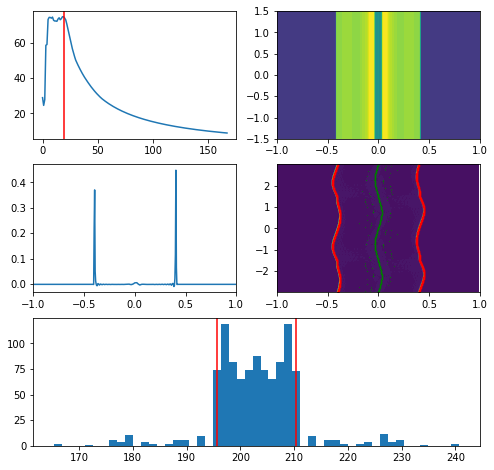

Amplitude: 2


100%|██████████| 201/201 [00:00<00:00, 731.29it/s]


 - maximum shock compression at i = 42
 - 2D snapshot not found. Continuing.
Amplitude: 5


100%|██████████| 201/201 [00:00<00:00, 942.23it/s] 


 - maximum shock compression at i = 38
 - 2D snapshot not found. Continuing.
Amplitude: 10


100%|██████████| 201/201 [00:00<00:00, 1028.69it/s]


 - maximum shock compression at i = 44
 - 2D snapshot not found. Continuing.
Amplitude: 20


100%|██████████| 201/201 [00:00<00:00, 559.57it/s]


 - maximum shock compression at i = 49
 - 2D snapshot not found. Continuing.
Amplitude: 50


100%|██████████| 201/201 [00:00<00:00, 694.70it/s]


 - maximum shock compression at i = 58
 - 2D snapshot not found. Continuing.
Amplitude: 75


100%|██████████| 201/201 [00:00<00:00, 673.29it/s]


 - maximum shock compression at i = 61
 - 2D snapshot not found. Continuing.
Amplitude: 100


100%|██████████| 201/201 [00:00<00:00, 1151.92it/s]


 - maximum shock compression at i = 65
 - 2D snapshot not found. Continuing.
Done.


In [38]:
measure_shocks('corrT1_dens')

In [39]:
measure_shocks('corrT2_press', amplitudes=[20,])

Amplitude: 20


100%|██████████| 201/201 [00:00<00:00, 1167.31it/s]

 - maximum shock compression at i = 47


 - 2D snapshot not found. Continuing.
Done.


100%|██████████| 201/201 [00:00<00:00, 1114.78it/s]


Maximum shock compression at i = 48


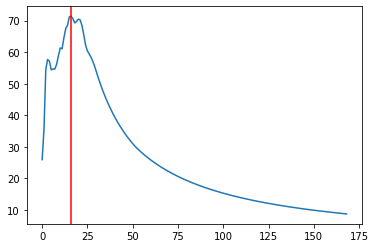

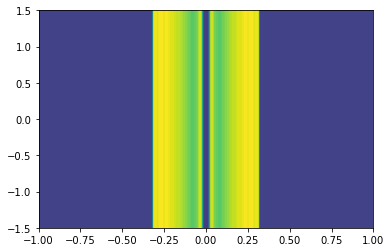

In [55]:
measure_shocks('corrT3_vel')